# HDBSCAN should work well on embedding representations

In [1]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

import lib.helper as helper
import lib.embedding_models as reps

from importlib import reload

%matplotlib inline

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_world_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 495
9.9 percent of files read.
19.8 percent of files read.
29.7 percent of files read.
39.6 percent of files read.
49.5 percent of files read.
59.4 percent of files read.
69.3 percent of files read.
79.2 percent of files read.
89.1 percent of files read.
99.0 percent of files read.
(31393, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 70: The weddings 'ruined' by Kashmir's...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

## 2a.  Try a really simple averaged word vector model!

With a complex noun extraction function 'cause that part's slow so I multi-threaded it.

In [73]:
from gensim.models import Word2Vec
import spacy
nlp = spacy.load('en_core_web_sm')
from gensim.models.phrases import Phrases, Phraser

# Set vector size
vec_size = 100

In [74]:
def get_phrased_nouns(sentences):
    """ Use spacy to get all of the actual entities, conjoin bigram nouns. """

    # Get the lists of nouns
    noun_lists = []
    for doc in sentences:
        parsed = nlp(doc)
        noun_lists.append([token.lemma_ for token in parsed if token.pos_ == 'PROPN'])

    # Build the phrase model
    phrases = Phrases(noun_lists, min_count=5, threshold=0.5)

    # Get the set of phrases present in the model
    results = []
    for nouns in noun_lists:
        results.append(phrases[nouns])

    return results

# Get phrase-conjoined, lemmatized tokens
test = get_phrased_nouns(corpus['clean_text'])

# Detect and conjoin bigrams
model = Word2Vec(test, size=vec_size, window=5, min_count=1, workers=10)

In [75]:
def get_averaged_vec(token_list, model):
    
    vecs = []
    for token in token_list:
        try:
            vector = model.wv[token]
        except: 
            vector = np.zeros(vec_size)
        vecs.append(vector)
    
    if len(vecs) > 0:
        return np.mean(np.asarray(vecs), axis=0)
    else:
        return np.zeros(vec_size)

In [76]:
vectors = [get_averaged_vec(tokens, model) for tokens in test]

## 3. Cluster Text

This is the part where the pipelines get a little more experimental
- First; PCA (HDBSCAN prefers < 50 dimensions if possible) (also, try just fitting 50 vectors!)
- Second; HDBSCAN clustering

In [77]:
embeddings_array = np.vstack(vectors)

# First, PCA the data
pca = PCA(n_components=20, svd_solver='full')

# Fit and check
embeddings_pca = pca.fit_transform(embeddings_array)

# Diagnostic stats - both should show exponential decay
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

[9.95536178e-01 1.75261072e-03 1.38806206e-03 5.18848828e-04
 1.62918490e-04 1.17912307e-04 5.37875824e-05 3.09597526e-05
 2.16703122e-05 1.85276282e-05 1.69522704e-05 1.55483887e-05
 1.41931649e-05 1.21487195e-05 1.15226255e-05 1.12968220e-05
 9.96805903e-06 9.30577028e-06 8.99574521e-06 8.19691780e-06]
[166.88976926   7.00235175   6.23168701   3.80997048   2.13494347
   1.81627146   1.22671084   0.93067904   0.77863474   0.71996454
   0.68867628   0.65954417   0.63014547   0.58299717   0.56777585
   0.5621851    0.52808823   0.51024335   0.50167189   0.47887976]


In [78]:
# Clusterer fitting
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
clusterer.fit(embeddings_pca)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(clusterer.labels_ == -1) / clusterer.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(clusterer.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = clusterer.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0 - clusterer.outlier_scores_

corpus.to_csv("working/RSS_clustered_w2v_pca.csv", index=False)

Percent outlier:  67.35896537444653
Number of clusters:  222


C:\ProgramData\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


In [79]:
# For calculating silhouette score, a gauge of how well separated clusters
# are in some spatial representation
from sklearn.metrics import silhouette_score

# Filter out the outliers
embeddings_score = embeddings_pca[clusterer.labels_ != -1]
labels_score = clusterer.labels_[clusterer.labels_ != -1]

score = silhouette_score(embeddings_score, labels_score, metric="cosine")
score

-0.06178694275540106

In [80]:
Counter(clusterer.labels_)

Counter({-1: 21146,
         220: 4448,
         214: 897,
         169: 14,
         154: 18,
         44: 30,
         86: 5,
         2: 100,
         30: 34,
         62: 21,
         20: 29,
         83: 36,
         219: 255,
         4: 44,
         104: 26,
         36: 13,
         59: 30,
         5: 65,
         82: 136,
         168: 10,
         12: 17,
         34: 8,
         119: 10,
         13: 48,
         103: 19,
         151: 37,
         102: 16,
         35: 17,
         179: 19,
         88: 13,
         132: 17,
         65: 22,
         186: 7,
         26: 13,
         111: 13,
         67: 6,
         192: 7,
         10: 16,
         27: 7,
         55: 19,
         135: 23,
         162: 10,
         126: 14,
         105: 28,
         99: 8,
         24: 13,
         206: 69,
         150: 5,
         124: 5,
         107: 5,
         93: 22,
         117: 12,
         100: 22,
         1: 5,
         177: 16,
         184: 54,
         158: 29,
        

c_v: 0.5477
c_npmi: 0.0571
Average document word count: 39.30287006657535
Number of documents: 31393
Latest record: Wed, 9 Oct 2019 21:52:38 +0000
Earliest record: Fri, 01 May 2020 00:18:25 GMT
Number of clusters: 222
Median cluster size: 14.0
Clustered docs: 32.6%

Best Performant (C_v)!
673      Zimbabwe: Police fire teargas, beat up anti-go...
6396     More than 50 elephants starve to death amid se...
9755     Zimbabwe health crisis: 'My cousin died as the...
14422    Zimbabwe doctors end strike after billionaire'...
Name: clean_text, dtype: object
14276    Coronavirus: First case of deadly Chinese viru...
14768    Coronavirus: Second patient confirmed in US as...
15998    Coronavirus: American evacuee infected with de...
16932    Coronavirus: US senator keeps repeating debunk...
Name: clean_text, dtype: object
4135     Bernie Sanders cancels campaign events after c...
4149     What is the heart stent surgery Bernie Sanders...
17350    Top heart doctor urges Bernie Sanders to relea.

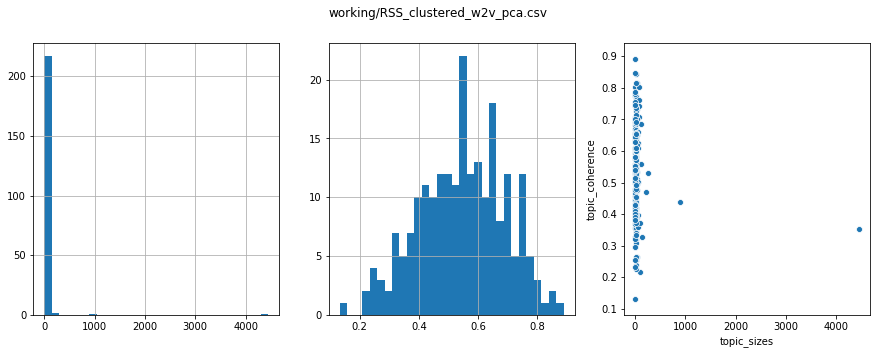

In [81]:
coherences = helper.report_corpus_model_coherence("working/RSS_clustered_w2v_pca.csv")

## 4. Cluster text with Spectral Clustering
Not working on high-dimensional data

## 5. Cluster text with Kmeans

Percent outlier:  0.0
Number of clusters:  200
c_v: 0.5322
c_npmi: 0.0385
Average document word count: 39.30287006657535
Number of documents: 31393
Latest record: Wed, 9 Oct 2019 21:52:38 +0000
Earliest record: Fri, 01 May 2020 00:18:25 GMT
Number of clusters: 200
Median cluster size: 75.0
Clustered docs: 100.0%

Best Performant (C_v)!
168    Iranian official mocks Trump with apos;good mo...
242    Climate crisis: Trump to roll back Obama-era p...
337    Iranian president snubs Trump offer of talks u...
693    El Paso mayor says Trump insulted him with apo...
Name: clean_text, dtype: object
109    Kabul explosion: At least 16 dead in Taliban a...
280    Israeli plan for new West Bank homes branded a...
407    Nasa investigating first ever apos;space crime...
431    Japan lashes out at South Korea as worst relat...
Name: clean_text, dtype: object
725     500 refugees stranded at sea as Europe argues ...
771     Trump is on yet another summer golfing holiday...
809     Jeffrey Epstein: F

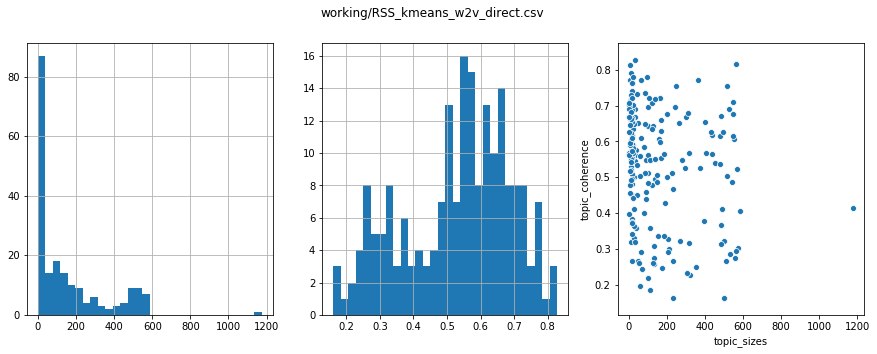

In [90]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_array)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_kmeans_w2v_direct.csv", index=False)

coherences = helper.report_corpus_model_coherence("working/RSS_kmeans_w2v_direct.csv")

Percent outlier:  0.0
Number of clusters:  200
c_v: 0.5215
c_npmi: 0.0322
Average document word count: 39.30287006657535
Number of documents: 31393
Latest record: Wed, 9 Oct 2019 21:52:38 +0000
Earliest record: Fri, 01 May 2020 00:18:25 GMT
Number of clusters: 200
Median cluster size: 68.0
Clustered docs: 100.0%

Best Performant (C_v)!
8741     New Zealand to hold referendum on euthanasia. ...
10852    New Zealand volcano: The moment after eruption...
10853    New Zealand: Moment of White Island volcano er...
10856    New Zealand eruption: No survivors on White Is...
Name: clean_text, dtype: object
57      Hurricane Dorian: Democratic presidential cand...
1834    First picture of Brit travel blogger thrown in...
2237    Vehicles left wrecked by roadside in Spain aft...
2379    Russia holds 80 North Koreans on 'poaching' bo...
Name: clean_text, dtype: object
39     Hurricane Dorian: Millions ordered to evacuate...
127    Hurricane Dorian: Trump sends 122 storm tweets...
483    Fires cou

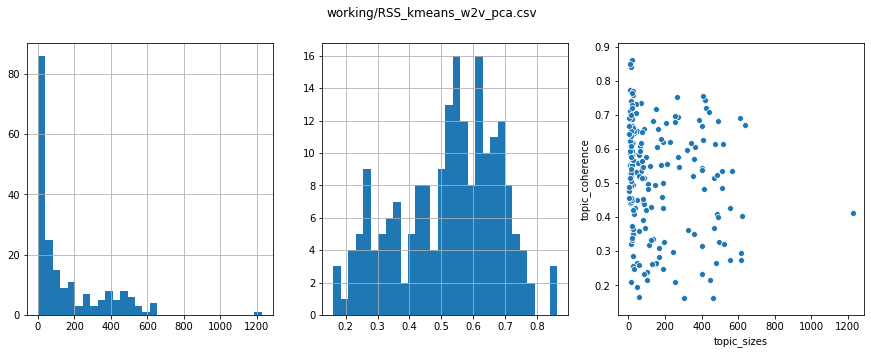

In [91]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_pca)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_kmeans_w2v_pca.csv", index=False)

coherences = helper.report_corpus_model_coherence("working/RSS_kmeans_w2v_pca.csv")